In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

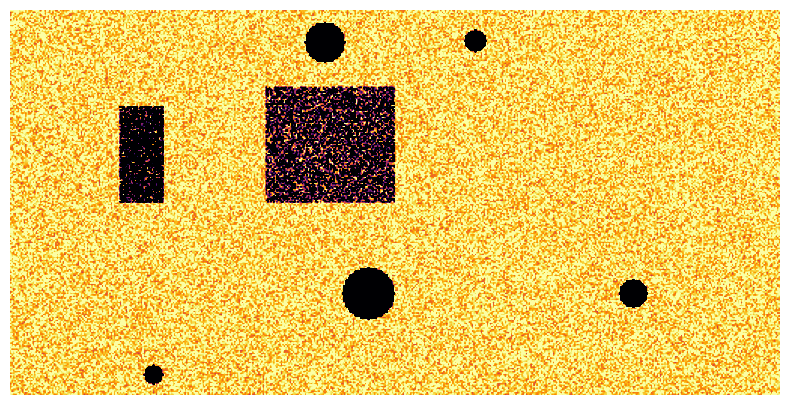

In [12]:
width = 512
height = 256


center_x, center_y = width // 2, height // 2
radius = width // 4
mask = np.ones((height, width))
# for i in range(height):
#     for j in range(width):
#         distance = np.sqrt(((i - center_y) ** 2) + ((j - center_x) ** 2))
#         mask[i, j] = 1 if distance <= radius else 0


background_noise = np.random.rand(height, width) * 0.2

hot_spots = np.random.rand(height, width) * 0.3 * mask
hot_spots[height // 5: height // 2, width // 3: width // 2] *= 5
hot_spots[height // 4: height // 2, width // 7: width // 5] *= 10

temperature = background_noise + hot_spots

# Add small circles
num_circles = 5
for _ in range(num_circles):
    x = np.random.randint(0, width)
    y = np.random.randint(0, height)
    radius = np.random.randint(5, 20)

    for i in range(height):
        for j in range(width):
            distance = np.sqrt((i - y) ** 2 + (j - x) ** 2)
            if distance <= radius:
                temperature[i, j] += 5

# Set background to black
temperature -= temperature.min()

cmap = 'inferno_r'
vmin, vmax = 0.2, 0.8
fig, ax = plt.subplots(figsize=(10, 5))
heatmap = ax.imshow(temperature, cmap=cmap, vmin=vmin, vmax=vmax)
# plt.colorbar(heatmap, label='Temperature')
plt.axis('off')
plt.savefig(f"dots.png", bbox_inches='tight')
plt.show()


# Approximation 1
Taking the maximum dimension of a blob and rotating it around that axis.


Areas and volumes of each blobbed region:
Blob 1: Area = 1729.50 square pixels, Volume = 193704.00 cubic pixels
Blob 2: Area = 2080.50 square pixels, Volume = 110266.50 cubic pixels
Blob 3: Area = 2358.50 square pixels, Volume = 313680.50 cubic pixels
Blob 4: Area = 2211.00 square pixels, Volume = 271953.00 cubic pixels
Blob 5: Area = 4176.50 square pixels, Volume = 413473.50 cubic pixels
Blob 6: Area = 14391.00 square pixels, Volume = 1899612.00 cubic pixels


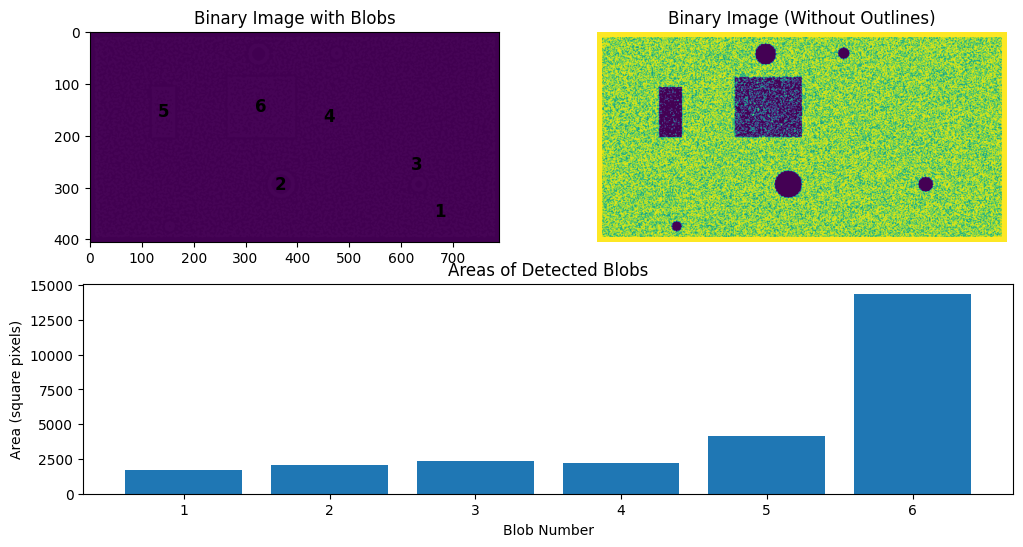

In [13]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def BlobbingAndDistanceCalculation(image):
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
    thresh = cv2.adaptiveThreshold(blurred_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                  cv2.THRESH_BINARY_INV, 11, 2)

    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filtered_contours = []
    areas = []
    max_dimension_volume = []

    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > 1500:
            filtered_contours.append(cnt)
            areas.append(area)
            x, y, w, h = cv2.boundingRect(cnt)
            max_dimension = max(w, h)
            volume = area * max_dimension  # Corrected volume calculation
            max_dimension_volume.append(volume)

    plt.figure(figsize=(12, 6))
    plt.subplot(2, 2, 1)
    plt.imshow(thresh, cmap='gray')
    plt.title("Binary Image with Blobs")

    for i, cnt in enumerate(filtered_contours):
        mask = np.zeros(image.shape, dtype="uint8")
        plt.imshow(mask, alpha=0.5)
        x, y, w, h = cv2.boundingRect(cnt)
        text_center = (x + w // 2, y + h // 2)
        plt.text(text_center[0], text_center[1], f"{i+1}", color='black', ha='center', va='center',
                 fontsize=12, fontweight='bold')

    plt.subplot(2, 2, 2)
    plt.imshow(image)
    plt.axis('off')
    plt.title("Binary Image (Without Outlines)")

    print("\nAreas and volumes of each blobbed region:")
    for i, (area, volume) in enumerate(zip(areas, max_dimension_volume), start=1):
        print(f"Blob {i}: Area = {area:.2f} square pixels, Volume = {volume:.2f} cubic pixels")

    return len(filtered_contours), areas, max_dimension_volume


image = cv2.imread("dots.png", cv2.IMREAD_GRAYSCALE)
num_blobs, areas, max_dimension_volume = BlobbingAndDistanceCalculation(image)

plt.subplot(2, 1, 2)
plt.bar(list(range(1, num_blobs + 1)), areas)
plt.xlabel("Blob Number")
plt.ylabel("Area (square pixels)")
plt.title("Areas of Detected Blobs")

plt.show()


# Approximation 2
Take maximum cross section from top / hole view and estimate the volume
- won't work for large gaps.
- optimal for small gaps

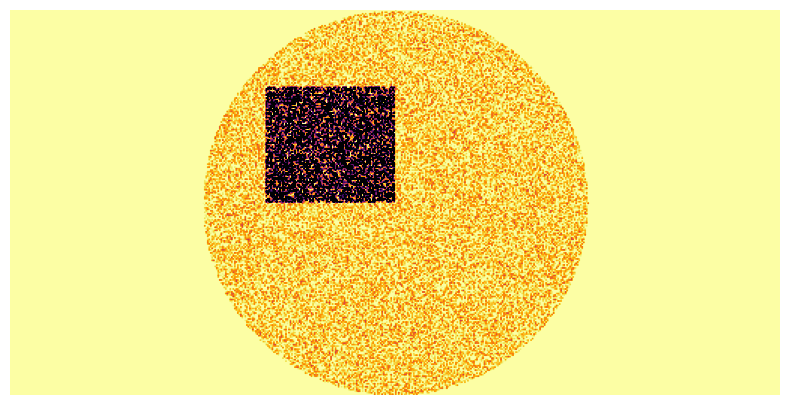

In [14]:
import numpy as np
import matplotlib.pyplot as plt

width = 512
height = 256

center_x, center_y = width // 2, height // 2
radius = width // 4
mask = np.zeros((height, width))
for i in range(height):
    for j in range(width):
        distance = np.sqrt(((i - center_y) ** 2) + ((j - center_x) ** 2))
        mask[i, j] = 1 if distance <= radius else 0

background_noise = np.random.rand(height, width) * 0.2

hot_spots = np.random.rand(height, width) * 0.3 * mask
hot_spots[height // 5: height // 2, width // 3: width // 2] *=5
hot_spots[height // 4: height // 2, width // 7: width // 5] *=10

temperature = background_noise + hot_spots
temperature[temperature < background_noise.max()] = background_noise.max()


cmap = 'inferno_r' 
vmin, vmax = 0.2, 0.8  
fig, ax = plt.subplots(figsize=(10, 5))
heatmap = ax.imshow(temperature, cmap=cmap, vmin=vmin, vmax=vmax)
# plt.colorbar(heatmap, label='Temperature')
plt.axis('off') 
plt.savefig(f"topview.png")
plt.show()




Areas, volumes, and maximum end-to-end distances of each blobbed region:


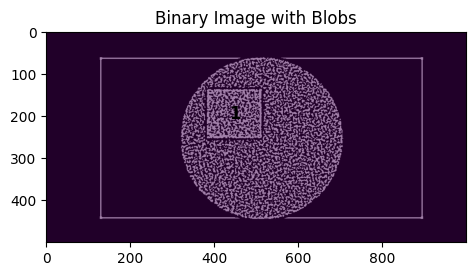

In [15]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def BlobbingAndDistanceCalculation(image):
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
    thresh = cv2.adaptiveThreshold(blurred_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                  cv2.THRESH_BINARY_INV, 11, 2)

    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filtered_contours = []
    areas = []
    volumes = []
    max_distances = []

    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > 3000:
            filtered_contours.append(cnt)
            areas.append(area)
            x, y, w, h = cv2.boundingRect(cnt)
            max_dimension = max(w, h)
            hull = cv2.convexHull(cnt)
            max_dist = 0
            for i in range(len(hull)):
                for j in range(i+1, len(hull)):
                    dist = np.linalg.norm(hull[i][0] - hull[j][0])
                    if dist > max_dist:
                        max_dist = dist
            max_distances.append(max_dist)

    plt.figure(figsize=(12, 6))
    plt.subplot(2, 2, 1)
    plt.imshow(thresh, cmap='gray')
    plt.title("Binary Image with Blobs")

    for i, cnt in enumerate(filtered_contours):
        mask = np.zeros(image.shape, dtype="uint8")
        plt.imshow(mask, alpha=0.5)
        x, y, w, h = cv2.boundingRect(cnt)
        text_center = (x + w // 2, y + h // 2)
        plt.text(text_center[0], text_center[1], f"{i+1}", color='black', ha='center', va='center',
                 fontsize=12, fontweight='bold')


    print("\nAreas, volumes, and maximum end-to-end distances of each blobbed region:")
    for i, (area, volume, max_dist) in enumerate(zip(areas, volumes, max_distances), start=1):
        print(f"Blob {i}: Area = {area:.2f} square pixels, Volume = {volume:.2f} cubic pixels, Max distance = {max_dist:.2f} pixels")

    return len(filtered_contours), areas, volumes, max_distances


image = cv2.imread("topview.png", cv2.IMREAD_GRAYSCALE)
num_blobs, areas, volumes, max_distances = BlobbingAndDistanceCalculation(image)

plt.show()


1729.5 174.22973339817747
2080.5 174.22973339817747
2358.5 174.22973339817747
2211.0 174.22973339817747
4176.5 174.22973339817747
14391.0 174.22973339817747

Areas and volumes of each blobbed region:
Blob 1: Area = 1729.50 square pixels, Volume = 301330.32 cubic pixels
Blob 2: Area = 2080.50 square pixels, Volume = 362484.96 cubic pixels
Blob 3: Area = 2358.50 square pixels, Volume = 410920.83 cubic pixels
Blob 4: Area = 2211.00 square pixels, Volume = 385221.94 cubic pixels
Blob 5: Area = 4176.50 square pixels, Volume = 727670.48 cubic pixels
Blob 6: Area = 14391.00 square pixels, Volume = 2507340.09 cubic pixels


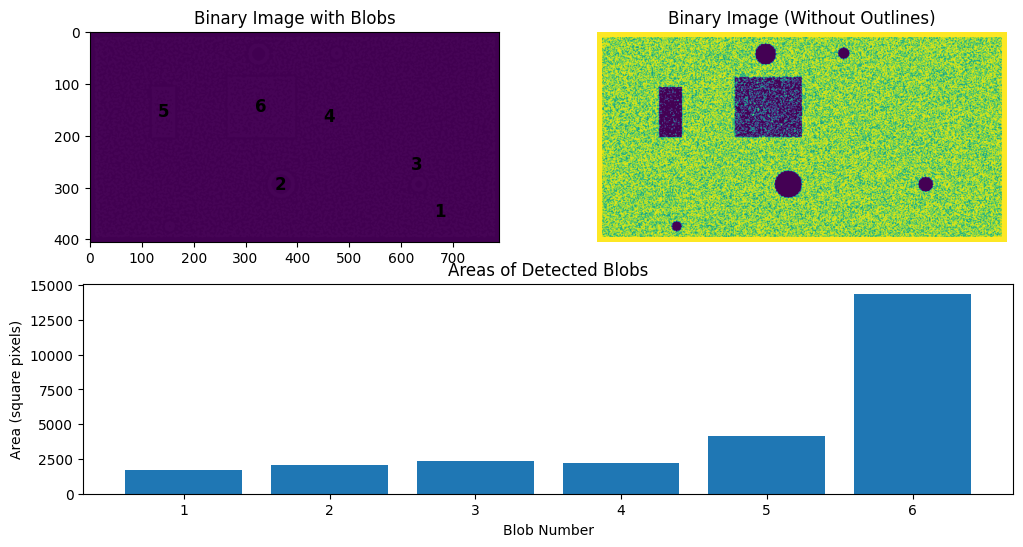

In [16]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def BlobbingAndDistanceCalculation(image):
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
    thresh = cv2.adaptiveThreshold(blurred_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                  cv2.THRESH_BINARY_INV, 11, 2)

    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filtered_contours = []
    areas = []
    cross_section_volume = []

    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > 1500:
            filtered_contours.append(cnt)
            areas.append(area)
            x, y, w, h = cv2.boundingRect(cnt)
            print(area, max(max_distances))
            volume = area * max(max_distances)
            cross_section_volume.append(volume)

    plt.figure(figsize=(12, 6))
    plt.subplot(2, 2, 1)
    plt.imshow(thresh, cmap='gray')
    plt.title("Binary Image with Blobs")

    for i, cnt in enumerate(filtered_contours):
        mask = np.zeros(image.shape, dtype="uint8")
        plt.imshow(mask, alpha=0.5)
        x, y, w, h = cv2.boundingRect(cnt)
        text_center = (x + w // 2, y + h // 2)
        plt.text(text_center[0], text_center[1], f"{i+1}", color='black', ha='center', va='center',
                 fontsize=12, fontweight='bold')

    plt.subplot(2, 2, 2)
    plt.imshow(image)
    plt.axis('off')
    plt.title("Binary Image (Without Outlines)")

    print("\nAreas and volumes of each blobbed region:")
    for i, (area, volume) in enumerate(zip(areas, cross_section_volume), start=1):
        print(f"Blob {i}: Area = {area:.2f} square pixels, Volume = {volume:.2f} cubic pixels")

    return len(filtered_contours), areas, cross_section_volume


image = cv2.imread("dots.png", cv2.IMREAD_GRAYSCALE)
num_blobs, areas, cross_section_volume = BlobbingAndDistanceCalculation(image)

plt.subplot(2, 1, 2)
plt.bar(list(range(1, num_blobs + 1)), areas)
plt.xlabel("Blob Number")
plt.ylabel("Area (square pixels)")
plt.title("Areas of Detected Blobs")

plt.show()


# Spherical Approximation
- considering the objects as spheres


Areas and volumes of each blobbed region:
Blob 1: Area = 1729.50 square pixels, Volume = 54105.90 cubic pixels
Blob 2: Area = 2080.50 square pixels, Volume = 71386.38 cubic pixels
Blob 3: Area = 2358.50 square pixels, Volume = 86162.37 cubic pixels
Blob 4: Area = 2211.00 square pixels, Volume = 78207.23 cubic pixels
Blob 5: Area = 4176.50 square pixels, Volume = 203040.43 cubic pixels
Blob 6: Area = 14391.00 square pixels, Volume = 1298674.34 cubic pixels


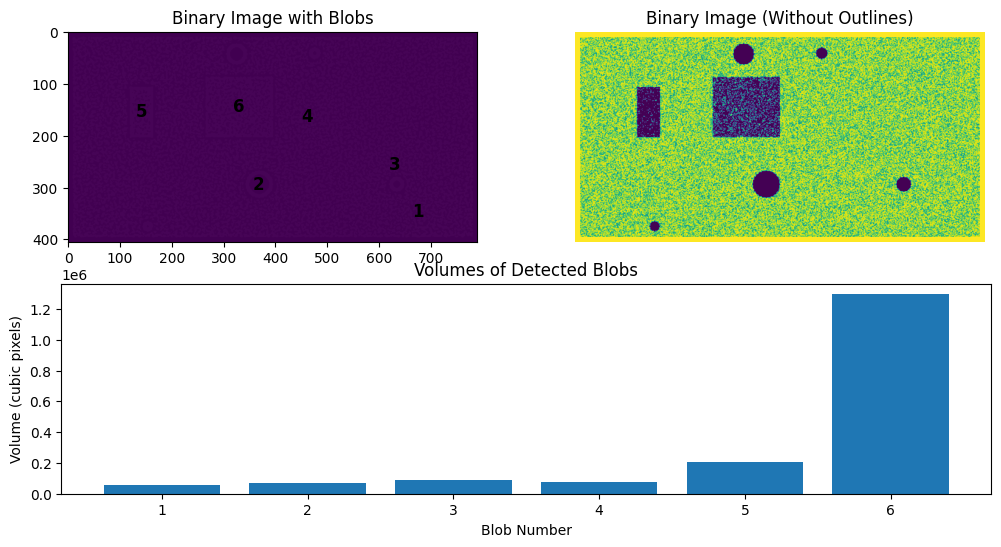

In [17]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def BlobbingAndDistanceCalculation(image):
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
    thresh = cv2.adaptiveThreshold(blurred_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                  cv2.THRESH_BINARY_INV, 11, 2)

    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filtered_contours = []
    areas = []
    spherical_volume = []

    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > 1500:
            filtered_contours.append(cnt)
            areas.append(area)
            radius = np.sqrt(area / np.pi)
            
            volume = (4/3) * np.pi * (radius ** 3)
            spherical_volume.append(volume)

    plt.figure(figsize=(12, 6))
    plt.subplot(2, 2, 1)
    plt.imshow(thresh, cmap='gray')
    plt.title("Binary Image with Blobs")

    for i, cnt in enumerate(filtered_contours):
        mask = np.zeros(image.shape, dtype="uint8")
        plt.imshow(mask, alpha=0.5)
        x, y, w, h = cv2.boundingRect(cnt)
        text_center = (x + w // 2, y + h // 2)
        plt.text(text_center[0], text_center[1], f"{i+1}", color='black', ha='center', va='center',
                 fontsize=12, fontweight='bold')

    plt.subplot(2, 2, 2)
    plt.imshow(image)
    plt.axis('off')
    plt.title("Binary Image (Without Outlines)")

    print("\nAreas and volumes of each blobbed region:")
    for i, (area, volume) in enumerate(zip(areas, spherical_volume), start=1):
        print(f"Blob {i}: Area = {area:.2f} square pixels, Volume = {volume:.2f} cubic pixels")

    return len(filtered_contours), areas, spherical_volume


image = cv2.imread("dots.png", cv2.IMREAD_GRAYSCALE)
num_blobs, areas, spherical_volume = BlobbingAndDistanceCalculation(image)

plt.subplot(2, 1, 2)
plt.bar(list(range(1, num_blobs + 1)), spherical_volume)
plt.xlabel("Blob Number")
plt.ylabel("Volume (cubic pixels)")
plt.title("Volumes of Detected Blobs")

plt.show()


# 3D Scanning and reconstruction 
- best, but expensive

In [23]:
print(max_dimension_volume)
print(cross_section_volume)
print(spherical_volume)
ensemble_volume = np.mean([max_dimension_volume, cross_section_volume, spherical_volume], axis=0)

print(ensemble_volume)

[193704.0, 110266.5, 313680.5, 271953.0, 413473.5, 1899612.0]
[301330.32391214796, 362484.9603349082, 410920.82621960156, 385221.9405433704, 727670.4815374882, 2507340.093333172]
[54105.903024701925, 71386.38345029781, 86162.36700136056, 78207.23182305777, 203040.43204375455, 1298674.3414273914]
[ 183046.74231228  181379.28126174  270254.56440699  245127.39078881
  448061.47119375 1901875.47825352]


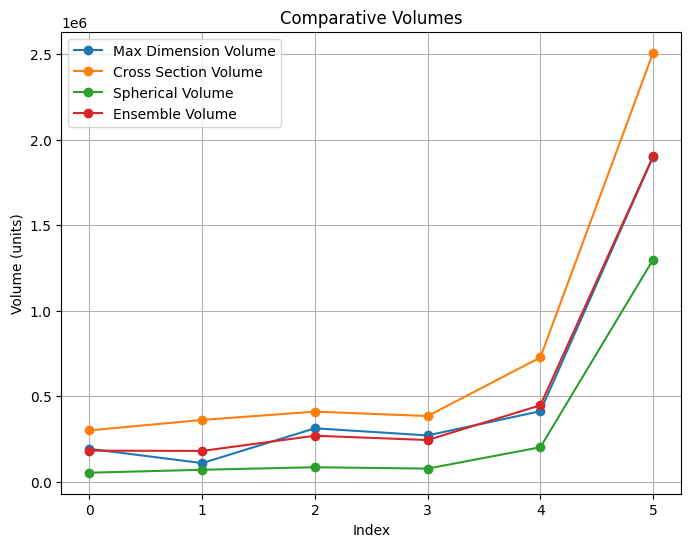

In [25]:
x_values = range(len(max_dimension_volume))

# Plotting each array as a separate line
plt.figure(figsize=(8, 6))
plt.plot(x_values, max_dimension_volume, label='Max Dimension Volume', marker='o')
plt.plot(x_values, cross_section_volume, label='Cross Section Volume', marker='o')
plt.plot(x_values, spherical_volume, label='Spherical Volume', marker='o')
plt.plot(x_values, ensemble_volume, label='Ensemble Volume', marker='o')

# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Volume (units)')
plt.title('Comparative Volumes')
plt.legend()

# Displaying the plot
plt.grid(True)
plt.show()